In [1]:
import os
import gc
from multiprocessing import Pool
from functools import partial
import numpy as np
import glob

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

from rdkit import Chem

from sklearn.metrics import accuracy_score
import sklearn

from SmilesPE.pretokenizer import atomwise_tokenizer
from SmilesPE.pretokenizer import kmer_tokenizer

import string
import tqdm
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device,torch.cuda.is_available()

(device(type='cuda'), True)

### Parameters

In [2]:
trial = True # setting False saves the output files else not saved

In [3]:
### Output log file
if not trial:
    try:
        os.system("mkdir output_files")
    except:
        print ("Folder output_files already present")

    present_files = glob.glob("output_files/log_output_*.txt")
    log_file_name = "output_files/log_output_" + str(len(present_files) + 1) + ".txt"
    log_file = open(log_file_name,"w",1)

In [63]:
multi_files = True

if multi_files:
    input_file = ["first_5000.txt","ML_input_5338.txt"]
else:
    input_file = "first_5000.txt" # Input data containing smiles and label

if not trial:
    log_file.write("Used files " + str(input_file) + "\n")
    
number_of_augmentation = 1 # Data augmentation multiplier
train_percentage = 0.9 # Fraction to use for training (valida and test would be half of remaining data)
Number_of_workers = 8 # Number of CPU threads to use

#### Remove rdkit warnings (optional)

In [64]:
# To remove rdkit warning
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [65]:
def to_canonical_smiles(molecule):
    try:
        canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(molecule))
    except:
        canonical_smile = False
    return canonical_smile

def get_cluster_count(y_count):
    cluster_count = {}
    for y in y_count:
        if y not in cluster_count:
            cluster_count[y] = 1
        else:
            cluster_count[y] +=1
    return (cluster_count)

def randomize_smiles(smiles,random_smiles=[],iteration=5):
    try:
        m = Chem.MolFromSmiles(smiles)
        ans = list(range(m.GetNumAtoms()))
        np.random.shuffle(ans)
        nm = Chem.RenumberAtoms(m,ans)
        out_smiles = (Chem.MolToSmiles(nm, canonical=False, isomericSmiles=True, kekuleSmiles=False))
    except:
        return (False)
    
    if out_smiles not in random_smiles:
        return out_smiles
    else:
        iteration -= 1
        if iteration > 0:
            out_smiles = randomize_smiles(smiles,random_smiles,iteration)
            return out_smiles
        return (False)
    
def augment_smiles(count,iteration,smiles):
    random_smiles = []
    for i in range(count):
        if smiles != None:
            out_smiles = randomize_smiles(smiles,random_smiles,iteration=iteration)
            if out_smiles:
                random_smiles.append(out_smiles)
            else:
                break
        
    return random_smiles

def unpack_and_write_list(smiles,label,filename):
    for entry in smiles:
        if type(entry) == list:
            unpack_and_write_list(entry,label,filename)
        else:
            filename.write(entry + "," + str(label) + "\n")
    
def smiles_augmentation(df, N_rounds=1,iteration=5,data_set_type="train"):
    
    try:
        os.mkdir("data")
        os.mkdir("data/classification")
    except:
        pass
    
    filename = "data/classification/" + str(data_set_type) + "_aug_canonical_smiles.csv"

    aug_out = open(filename,"w")

    aug_out.write("Smiles,Label\n")
        
    labels = []
    for label in df.groupby('Label'):
        labels.append(label[0])
    
    augmentation_list = []
    if type(N_rounds) == list:
        assert(len(N_rounds) == len(labels))
        augmentation_list = N_rounds
    else:
        for i in range(len(labels)):
            augmentation_list.append(N_rounds)
        
    for label,augmentation in zip(labels,augmentation_list):
    
        canonical_smiles = df[df['Label'] == label]['Smiles'].to_list()

        p = Pool(Number_of_workers)
        func = partial(augment_smiles, augmentation, iteration)
        augmented_smiles = list(tqdm.tqdm(p.imap(func, canonical_smiles), total=len(canonical_smiles),leave=False))
        p.close()
    
        print ("Saving data for label = " + str(label))

        unpack_and_write_list(augmented_smiles,label,filename=aug_out)

        unpack_and_write_list(canonical_smiles,label,filename=aug_out)
        
        print ("Saved data for label = " + str(label))
        
    aug_out.close()
    
    return (pd.read_csv(filename, header=0).sample(frac=1).reset_index(drop=True))
    


In [66]:
if multi_files:
    for i,input_filename in enumerate(input_file):
        if i != 0:
            quantmap_data2 = pd.read_csv(input_filename,sep=" ",names=["Smiles", "Label"]).sample(frac=1).reset_index(drop=True) #,header=None)
            quantmap_data = pd.concat([quantmap_data,quantmap_data2])
        else:
            quantmap_data = pd.read_csv(input_filename,sep=" ",names=["Smiles", "Label"]).sample(frac=1).reset_index(drop=True) #,header=None)
    del quantmap_data2
else:
    quantmap_data = pd.read_csv(input_file,sep=" ",names=["Smiles", "Label"]).sample(frac=1).reset_index(drop=True)

    
print('Dataset:', quantmap_data.shape)
quantmap_data.head(5)

Dataset: (9854, 2)


,Smiles,Label
0,CCCCCCC(CC=CCCCCCCCC(=O)O)O,0
1,C(=CC=O)C=C(C(=O)O)N,1
2,CC1=C(SC=C1)C(=CCCN2CCCC(C2)C(=O)O)C3=C(C=CS3)C,2
3,C1CN(CC[NH+]1CCO)CCS(=O)(=O)[O-],1
4,CC1=C(C=C(C=C1)N=C=O)N=C=O,0


In [67]:
print (quantmap_data.groupby('Label').count())
if not trial:
    log_file.write("Class distribution before augmentation\n")
    log_file.write(str(quantmap_data.groupby('Label').count()) + "\n")
    
quantmap_data.groupby('Label').count()

       Smiles
Label        
0        1919
1        4662
2        2508
3         390
4         375


,Smiles
Label,
0,1919
1,4662
2,2508
3,390
4,375


In [68]:
label_count_df = quantmap_data.groupby('Label').count()
label_count_list = []
for entry in range(len(label_count_df)):
    label_count_list.append(label_count_df.iloc[entry][0])

augmentation_list = []
max_value = max(label_count_list)
for entry in label_count_list:
    augmentation_list.append(int(max_value/entry))

In [69]:
###
augmentation_list = [entry*number_of_augmentation for entry in augmentation_list]
iteration = 10000
# Augmentation for training data
quantmap_data = smiles_augmentation(quantmap_data,N_rounds=augmentation_list,iteration=iteration,data_set_type="all_data")

Saving data for label = 0
Saved data for label = 0


Saving data for label = 1
Saved data for label = 1


Saving data for label = 2
Saved data for label = 2


Saving data for label = 3
Saved data for label = 3


Saving data for label = 4
Saved data for label = 4


In [70]:
print (quantmap_data.groupby('Label').count())
if not trial:
    log_file.write("number of augmentation = " + str(number_of_augmentation) + "\n")
    log_file.write("Class distribution after augmentation\n")
    log_file.write(str(quantmap_data.groupby('Label').count()) + "\n")
    log_file.write("Train/valid split ratio = " + str(train_percentage) + "\n")
    
quantmap_data.groupby('Label').count()

       Smiles
Label        
0        5749
1        9323
2        5016
3        4569
4        4680


,Smiles
Label,
0,5749
1,9323
2,5016
3,4569
4,4680


### Data preparation

In [71]:
output_label = "None" #"fingerprint"
class MolTokenizer():
    def __init__(self, lang = 'en'):
        self.lang = lang
        
    def tokenizer(self, output_label=None,smiles=None):
        tokens = atomwise_tokenizer(smiles)
        tokens.insert(0, "<SOS>") 
        tokens.append("<EOS>") 
        if output_label != "fingerprint":
            return tokens
        else:
            try:
                fingerprint = smiles_fingerprint(smiles,"morgan", radius=2,bits=1024)
                return tokens,fingerprint
            except:
                return None,None
        
    def add_special_cases(self, toks):
        pass

tok = MolTokenizer()

In [72]:
# To make vocabulary

def unpack_vocab_list(vocab_list,vocab_unpacked):
    for entry in vocab_list:
        if type(entry) == list:
            unpack_vocab_list(entry,vocab_unpacked)
        else:
            vocab_unpacked.append(entry)
            
    return (vocab_unpacked)
            
def make_vocabulary(input_list):
    p = Pool(Number_of_workers)
    func = partial(tok.tokenizer, None)
    vocab_list = list(tqdm.tqdm(p.imap(func, input_list), total=len(input_list),leave=False))
    p.close()
    vocab_unpacked = []
    return (list(set(unpack_vocab_list(vocab_list,vocab_unpacked))))

def make_word_index(vocab):
    word_index = {}
    index_word = {}
    for i,entry in enumerate(vocab):
        word_index[entry] = i
        index_word[i] = entry
    return (word_index,index_word)

In [73]:
use_vocab_file = True

if use_vocab_file:
    en_vocab = open("en_vocab_.txt","r").read().strip("[]").replace("'", "").replace(" ", "").split(",")
    en_word_index,en_index_word = make_word_index(en_vocab)
    
else:
    all_smiles = quantmap_data["Smiles"].to_list()

    en_vocab = ["<PAD>","<UNK>"]
    en_vocab.extend(make_vocabulary(all_smiles))
    del all_smiles

    ###
    en_word_index,en_index_word = make_word_index(en_vocab)

    vocab_output = open("en_vocab_.txt","w")
    vocab_output.write(str(en_vocab))
    vocab_output.close()

In [74]:
len(en_vocab)

153

In [75]:
# Removing unbalanced data and shuffling
balanced_data = quantmap_data [quantmap_data.Label != 0][quantmap_data.Label != 1][quantmap_data.Label != 2]
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)
balanced_data["Label"].replace({3: 0,4:1}, inplace=True)
balanced_data.groupby('Label').count()

/home/jovyan/anaconda3/envs/molpmofit/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/jovyan/anaconda3/envs/molpmofit/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Smiles
Label,
0,4569
1,4680


In [76]:
if not trial:
    log_file.write("Class distribution after balanced dataset\n")
    log_file.write(str(balanced_data.groupby('Label').count()) + "\n")

In [77]:
class_count_list = np.array([entry for entry in balanced_data.groupby('Label').count()["Smiles"]])
class_weight = np.max(class_count_list)/class_count_list
class_weight = torch.FloatTensor(class_weight).cuda()

if not trial:
    log_file.write("Class weight for loss (balancing weights)= " + str(class_weight) + "\n")

In [78]:
def convert_smiles_to_tokens(df):
    
    if output_label != "fingerprint": # Maintain the y from the data as label
        labels = []
        for label in df.groupby('Label'):
            labels.append(label[0])
            
        x = []
        y = []
        p = Pool(Number_of_workers)
        for label in labels:
            smiles_list = df[df['Label'] == label]['Smiles'].to_list()
            
            
            func = partial(tok.tokenizer, None)
            tokens = list(tqdm.tqdm(p.imap(func, smiles_list), total=len(smiles_list),leave=False))
            
            #p = Pool(Number_of_workers)
            #tokens = list(tqdm.tqdm(p.imap(tok.tokenizer, smiles_list), total=len(smiles_list),leave=False))
            #p.close()
            #if len(tokens) < 100:
            for entry in tokens:
                if  5 < len(entry) <= 150:
                #break
                    x.append(entry)
                    y.append(label)
            #x.extend(tokens)
            #y.extend([label for i in range(len(tokens))])
        p.close()
            
    else: # Return fingerprint as label for each object
        x = []
        y = []
        smiles_list = df['Smiles'].to_list()
        
        func = partial(tok.tokenizer, output_label)
        
        for entry in smiles_list:
            xout,yout = (func(entry))
            if xout != None:
                x.append(xout)
                y.append([int(entry) for entry in yout])
        
        print (str(len(smiles_list)-len(x)) + " incorrect smiles detected and deleted"  )
        
    return (x,y)

In [79]:
x,y= convert_smiles_to_tokens(balanced_data)

In [80]:
lenthwise_x = [len(entry) for entry in x if len(entry)]
if not trial:
    log_file.write("Data point with (5 < len(sequence) <= 150) = " + str(len(lenthwise_x)) +"/"+ str(sum(class_count_list)) + "\n")

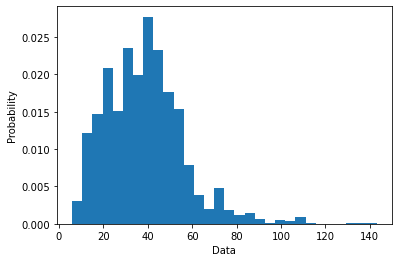

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(lenthwise_x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [82]:
def convert_token_to_index(molecule):
    idxs = []
    for ch in molecule:
        if ch in en_word_index:
            idxs.append(en_word_index[ch])
        else:
            idxs.append(en_word_index["<UNK>"])
    return torch.tensor(idxs)

In [83]:
x_indexed_token = []
loop = tqdm.tqdm(x, total=len(x),leave=False)
for entry in loop:
    x_indexed_token.append(convert_token_to_index(entry))

### Shuffling data

In [84]:
valid_test_percentage = (1 - train_percentage)/2

data_to_use = balanced_data
# Ratios
train_ratio = int (len(data_to_use) * train_percentage)
valid_ratio = train_ratio + int(len(data_to_use)*valid_test_percentage)
test_ratio = valid_ratio + int(len(data_to_use)*valid_test_percentage)

In [85]:
# Make index to split into train and val set
def make_index(len_data,train_ratio,valid_ratio,test_ratio):
    
    index = np.random.permutation(len_data)
    
    # Train index and val index
    return (index[:train_ratio],index[train_ratio:valid_ratio],index[valid_ratio:test_ratio])

train_index ,valid_index,test_index = make_index(len(data_to_use),train_ratio,valid_ratio,test_ratio)

### Dataloaders by padding the tokens

In [86]:
x_padded = pad_sequence(x_indexed_token,batch_first=True, padding_value=0)

In [87]:
from torch.utils.data import Dataset, TensorDataset, SubsetRandomSampler

train_sample = SubsetRandomSampler(train_index)
valid_sample = SubsetRandomSampler(valid_index)
test_sample = SubsetRandomSampler(test_index)
batch_size = 512


dataset = torch.utils.data.TensorDataset(x_padded,torch.tensor(y))

train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=batch_size,
                                        sampler=train_sample)

valid_loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                        sampler=valid_sample)

test_loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                        sampler=test_sample)

### Data without padding

In [88]:
def shuffle_data(data):
    
    index = np.random.permutation(len(data))
    
    output_shuffled = []
    for i in index:
        output_shuffled.append(data[i])
        
    return (output_shuffled)
    

In [89]:
train_data = shuffle_data([(entry,y[i]) for i,entry in enumerate(x_indexed_token) if i in train_index])
valid_data = shuffle_data([(entry,y[i]) for i,entry in enumerate(x_indexed_token) if i in valid_index])
test_data = shuffle_data([(entry,y[i]) for i,entry in enumerate(x_indexed_token) if i in test_index])

### Bucket iterator

In [90]:
class MakeDataset(Dataset):
    """PyTorch Dataset class for loading data.
      This is where the data parsing happens.
      This class is built with reusability in mind.
      Arguments:
      path (:obj:`str`):
      Path to the data partition.
      """
    
    def __init__(self, data_tuple):

        # Check if path exists.
        #if not os.path.isdir(path):
          # Raise error if path is invalid.
          #raise ValueError('Invalid `path` variable! Needs to be a directory')
    
        self.texts = []
        self.labels = []
        # Since the labels are defined by folders with data we loop 
        # through each label.
        '''for label  in ['pos', 'neg']:
            sentiment_path = os.path.join(path, label)

            # Get all files from path.
            files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
            # Go through each file and read its content.
            for file_name in tqdm(files_names, desc=f'{label} Files'):
                file_path = os.path.join(sentiment_path, file_name)

                # Read content.
                content = io.open(file_path, mode='r', encoding='utf-8').read()
                # Fix any unicode issues.
                content = fix_text(content)
                # Save content.
                self.texts.append(content)
                # Save labels.
                self.labels.append(label)'''
        for entry in data_tuple:
            self.texts.append(entry[0])
            self.labels.append(entry[1])
        # Number of examples.
        self.n_examples = len(self.labels)
        return


    def __len__(self):
        """When used `len` return the number of examples."""
        return self.n_examples


    def __getitem__(self, item):
        """Given an index return an example from the position.
        Arguments:
          item (:obj:`int`):
              Index position to pick an example to return.
        Returns:
          :obj:`Dict[str, str]`: Dictionary of inputs that are used to feed 
          to a model.
        """
        return {'text':self.texts[item], 'label':self.labels[item]}

In [91]:
train_dataset = MakeDataset(train_data)
valid_dataset = MakeDataset(valid_data)
test_dataset = MakeDataset(test_data)

from torchtext import data

batch_size = 16

train_iterator = data.BucketIterator(
    train_dataset,
    sort = False,
    sort_within_batch=True,
    sort_key=lambda x: len(x['text']),
    batch_size = batch_size,
    device = device)

valid_iterator = data.BucketIterator(
    valid_dataset,
    sort = False,
    shuffle=True,
    sort_within_batch=True,
    sort_key=lambda x: len(x['text']),
    batch_size = batch_size,
    device = device)

test_iterator = data.BucketIterator(
    test_dataset,
    sort = False,
    shuffle=True,
    sort_within_batch=True,
    sort_key=lambda x: len(x['text']),
    batch_size = batch_size,
    device = device)

if not trial:
    log_file.write("Batch size = " + str(batch_size) + "\n")

In [92]:
gc.collect()
torch.cuda.empty_cache()

### Load Pretrained Model

In [109]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size) #,padding_idx=0)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p,batch_first=True)

    def forward(self, x):
        # x shape: (N,seq_length) where N is batch size
        
        embedding = self.dropout(self.embedding(x))
        # embedding shape: (N,seq_length, embedding_size)
        
        outputs, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (N,seq_length, hidden_size)
        
        #cat = torch.cat(hidden[0],hidden[1],hidden[2],dim=2)
        #print (hidden.view(1,-1).shape)
        #print (hidden[2].shape)
        return hidden[2]
        #return hidden.view(-1,hidden[2].shape[1]*3)


class FC_layer(nn.Module):
    def __init__(
        self, hidden_size, output_size,p):
        super(FC_layer, self).__init__()
        
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(hidden_size, 1024)
        #self.bn1 = nn.BatchNorm1d(1024)
        
        #self.fc2 = nn.Linear(1024, 512)
        #self.bn2 = nn.BatchNorm1d(512)
        
        self.fc3 = nn.Linear(1024, output_size)

    def forward(self, hidden):
        fc_out = self.relu(self.dropout(self.fc1(hidden)))
        #fc_out = self.relu(self.dropout(self.fc2(fc_out)))
        #fc_out = self.dropout(self.fc2(fc_out))
        fc_out = self.fc3(fc_out)
        
        return fc_out


In [110]:
# Needs to be the same for both RNN's
hidden_size = 1024  
num_layers = 3



input_size_encoder = len(en_vocab)
en_embedding_size = 400
en_dropout = 0.4

encoder_net = Encoder(
    input_size_encoder, 
    en_embedding_size, 
    hidden_size, 
    num_layers, 
    en_dropout).to(device)

de_dropout = 0.4

output_size = len(set(y))

FC_layer = FC_layer(hidden_size, 
                   output_size,
                   de_dropout).to(device)

In [111]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, FC_layer):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.FC_layer = FC_layer
        self.softmax = nn.Softmax()
        
    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[0]

        hidden = self.encoder(source)
        outputs = self.FC_layer(hidden)
        
        #outputs = self.softmax(outputs)
        
        return outputs

In [112]:
import torch.optim as optim
import random

# Training hyperparameters
#epochs = 10
#learning_rate = 0.00005

model = Seq2Seq(encoder_net, FC_layer).to(device)
model.load_state_dict(torch.load("test_model.pth"), strict=False)
model.to(device)

#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weight)

### Train pretrained model

In [113]:
batched = False

def validate(val_dl):
    model.eval()
    total_loss = []
    accuracy = []
    
    with torch.no_grad():
        
        val_dl.create_batches()
        loop = tqdm.tqdm(enumerate(val_dl.batches), total=len(val_dl),leave=False)
        for i,batch in loop:
            batch_text = [example["text"] for example in batch]
            batch_label = torch.tensor([example["label"] for example in batch])
            x_padded = pad_sequence(batch_text,batch_first=True, padding_value=0)
            xvalc = x_padded.to(device)
            yvalc = batch_label.to(device)
            
            '''loop = tqdm.tqdm(enumerate(val_dl), total=len(val_dl),leave=False)
            for i, (xval,yval) in loop:
            xval = xval.view(1,-1)
            yval = yval.view(1,-1)
            xvalc = xval.to(device)
            yvalc = yval.to(device)'''

            # Forward prop
            output_val = model(xvalc.long(),yvalc)

            #print (output_train.shape,ybc.shape)

            accuracy.append(get_accuracy(output_val,yvalc))

            loss_val = criterion(output_val, yvalc)
            #loss_val = criterion(output_val, yvalc)

            total_loss.append(loss_val.item())
            
            loop.set_postfix(loss = sum(total_loss)/(i+1),acc = sum(accuracy)/(len(accuracy)))
    return (sum(total_loss)/(i+1),sum(accuracy)/(len(accuracy)))
    
def train(train_dl):
    model.train()
    total_loss = []
    accuracy = []
    
    
    train_dl.create_batches()
    loop = tqdm.tqdm(enumerate(train_dl.batches), total=len(train_dl),leave=False)
    
    for i,batch in loop:
        batch_text = [example["text"] for example in batch]
        batch_label = torch.tensor([example["label"] for example in batch])
        
        x_padded = pad_sequence(batch_text,batch_first=True, padding_value=0)
        
        xbc = x_padded.to(device)
        ybc = batch_label.to(device)
        
        '''loop = tqdm.tqdm(enumerate(train_dl), total=len(train_dl),leave=False)
        for i, (xb,yb) in loop:
    
        xb = xb.view(1,-1)
        yb = yb.view(1,-1)
        xbc = xb.to(device)
        ybc = yb.to(device)'''

        optimizer.zero_grad()
        
        # Forward prop
        output_train = model(xbc.long(),ybc)

        accuracy.append(get_accuracy(output_train,ybc))
        
        
        loss_train = criterion(output_train, ybc)
        
        # Back prop
        loss_train.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optimizer.step()

        total_loss.append(loss_train.item())
        loop.set_postfix(loss = sum(total_loss)/(i+1),acc = sum(accuracy)/(len(accuracy)))
        #if i % 1000 == 0:
        #    print ("Batch " + str(i) + " train loss = " + str(sum(total_loss)/(i+1)) )

        gc.collect()
    return (sum(total_loss)/(i+1),sum(accuracy)/(len(accuracy)))


def get_accuracy(yhat,y): #  FOR BCE ERROR
    
    if batched:
        batch_accuracy = []
        for batch in range(yhat.shape[0]):
            accuracy_list = []
            
            for i,entry in enumerate(yhat[batch]):
                softmax = torch.exp(entry.float())
                prob = list(softmax.cpu().detach().numpy())
                predictions = np.argmax(prob, axis=0)
                accuracy_list.append(np.argmax(y[batch][i].cpu().detach().numpy(), axis=0) == predictions != 0)
            batch_accuracy.append((np.sum(np.array(accuracy_list))*1.0)/len(accuracy_list))
            
        return np.sum(batch_accuracy)/len(batch_accuracy)
    
    else:
        
        accuracy_list = []
        #print (yhat.shape[0])
        for i,entry in enumerate(yhat):
            #if y[i].cpu().detach().numpy() != 0:
                #print (entry.shape)
            softmax = torch.exp(entry.float())
            prob = list(softmax.cpu().detach().numpy())
            predictions = np.argmax(prob, axis=0)
                #if random.random() > 0.99:
                #    print (predictions,y[i],y[i].cpu().detach().numpy())
            #print (yhat,predictions,y[i].cpu().detach().numpy())
            accuracy_list.append(y[i].cpu().detach().numpy() == predictions)
            
        return (np.sum(np.array(accuracy_list))*1.0)/len(yhat)

In [114]:
params = model.state_dict()
model,params.keys()

(Seq2Seq(
   (encoder): Encoder(
     (dropout): Dropout(p=0.4, inplace=False)
     (embedding): Embedding(153, 400)
     (rnn): LSTM(400, 1024, num_layers=3, batch_first=True, dropout=0.4)
   )
   (FC_layer): FC_layer(
     (dropout): Dropout(p=0.4, inplace=False)
     (relu): ReLU()
     (fc1): Linear(in_features=1024, out_features=1024, bias=True)
     (fc3): Linear(in_features=1024, out_features=2, bias=True)
   )
   (softmax): Softmax(dim=None)
 ),
 odict_keys(['encoder.embedding.weight', 'encoder.rnn.weight_ih_l0', 'encoder.rnn.weight_hh_l0', 'encoder.rnn.bias_ih_l0', 'encoder.rnn.bias_hh_l0', 'encoder.rnn.weight_ih_l1', 'encoder.rnn.weight_hh_l1', 'encoder.rnn.bias_ih_l1', 'encoder.rnn.bias_hh_l1', 'encoder.rnn.weight_ih_l2', 'encoder.rnn.weight_hh_l2', 'encoder.rnn.bias_ih_l2', 'encoder.rnn.bias_hh_l2', 'FC_layer.fc1.weight', 'FC_layer.fc1.bias', 'FC_layer.fc3.weight', 'FC_layer.fc3.bias']))

In [115]:
# Freezing layers except FC
model.encoder.embedding.weight.requires_grad = False

'''
lstm_list = [model.encoder.rnn.parameters()]

for entry in lstm_list:
    for param in entry:
        param.requires_grad = False'''

model.encoder.rnn.bias_hh_l2.requires_grad = False
model.encoder.rnn.bias_ih_l2.requires_grad = False
model.encoder.rnn.weight_hh_l2.requires_grad = False
model.encoder.rnn.weight_ih_l2.requires_grad = False

model.encoder.rnn.bias_hh_l1.requires_grad = False
model.encoder.rnn.bias_ih_l1.requires_grad = False
model.encoder.rnn.weight_hh_l1.requires_grad = False
model.encoder.rnn.weight_ih_l1.requires_grad = False

model.encoder.rnn.bias_hh_l0.requires_grad = False
model.encoder.rnn.bias_ih_l0.requires_grad = False
model.encoder.rnn.weight_hh_l0.requires_grad = False
model.encoder.rnn.weight_ih_l0.requires_grad = False



In [116]:
# List to store values
train_loss_list = []
train_accu_list = []
val_loss_list = []
val_accu_list = []
gc.collect()
torch.cuda.empty_cache()

In [117]:
#loop = tqdm.tqdm(range(epochs), total=epochs,leave=False)
epochs = 5
learning_rate = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=1e-4)

if not trial:
    log_file.write("model = " + str(model) + "\n")
    log_file.write("\nEmbedding layer and LSTM frozen\n")
    log_file.write("learning_rate = " + str(learning_rate) + "\n")
    log_file.write("epochs = " + str(epochs) + "\n")
    log_file.write("Epoch\tLOSStrain\tLOSSval\tACCUtrain\tACCUval\n") 
    
    
for epoch in range(epochs):
    
    #print ("EPOCH " + str(epoch))
    
    train_loss, train_accu = train(train_iterator)
    train_loss_list.append(train_loss)
    train_accu_list.append(train_accu)
    
    val_loss,val_accu = validate(valid_iterator)
    val_loss_list.append(val_loss)
    val_accu_list.append(val_accu)
    
    if not trial:
        log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
        torch.save(model.state_dict(), "pretrained_model_epoch" + str(epoch) + ".pth")
    print ("Epoch :",epoch+1,"\t","LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)

  0%|          | 1/520 [00:00<01:04,  8.03it/s, acc=0.719, loss=0.617]  

Epoch : 1 	 LOSS train: 0.677619184152438  val: 0.6610576695409315 	ACCU train: 0.5755791083916084  val: 0.5754310344827587


  0%|          | 2/520 [00:00<01:16,  6.78it/s, acc=0.812, loss=0.588]  

Epoch : 2 	 LOSS train: 0.6673664428866827  val: 0.6468578762021558 	ACCU train: 0.5885489510489511  val: 0.6170977011494252


  0%|          | 1/520 [00:00<00:56,  9.19it/s, acc=0.562, loss=0.682]  

Epoch : 3 	 LOSS train: 0.6622495639209564  val: 0.6411881200198469 	ACCU train: 0.5996066433566434  val: 0.6106321839080461


  0%|          | 2/520 [00:00<00:56,  9.15it/s, acc=0.75, loss=0.572]   

Epoch : 4 	 LOSS train: 0.6590420904067846  val: 0.6333003784048146 	ACCU train: 0.6049497377622377  val: 0.6278735632183909


Epoch : 5 	 LOSS train: 0.6574995993421628  val: 0.6385497882448393 	ACCU train: 0.6058457167832169  val: 0.6149425287356322


In [118]:
# Freezing layers except FC and lstm last layer
model.encoder.rnn.bias_hh_l2.requires_grad = True
model.encoder.rnn.bias_ih_l2.requires_grad = True
model.encoder.rnn.weight_hh_l2.requires_grad = True
model.encoder.rnn.weight_ih_l2.requires_grad = True



In [119]:
#loop = tqdm.tqdm(range(epochs), total=epochs,leave=False)
epochs = 3
learning_rate = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=1e-4)

if not trial:
    log_file.write("\nEmbedding layer and LSTM frozen (except last layer)\n")
    log_file.write("learning_rate = " + str(learning_rate) + "\n")
    log_file.write("epochs = " + str(epochs) + "\n")
    log_file.write("Epoch\tLOSStrain\tLOSSval\tACCUtrain\tACCUval\n") 
    
    
for epoch in range(epochs):
    
    #print ("EPOCH " + str(epoch))
    
    train_loss, train_accu = train(train_iterator)
    train_loss_list.append(train_loss)
    train_accu_list.append(train_accu)
    
    val_loss,val_accu = validate(valid_iterator)
    val_loss_list.append(val_loss)
    val_accu_list.append(val_accu)
    
    if not trial:
        log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
        torch.save(model.state_dict(), "pretrained_model_epoch" + str(epoch) + ".pth")
    print ("Epoch :",epoch+1,"\t","LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)

  0%|          | 2/520 [00:00<00:57,  9.01it/s, acc=0.562, loss=0.717]  

Epoch : 1 	 LOSS train: 0.6514123562436838  val: 0.6336196486292214 	ACCU train: 0.6118662587412588  val: 0.6214080459770115


  0%|          | 2/520 [00:00<01:12,  7.10it/s, acc=0.656, loss=0.651]  

Epoch : 2 	 LOSS train: 0.6470954046799586  val: 0.6216289041371181 	ACCU train: 0.618597027972028  val: 0.6472701149425287


Epoch : 3 	 LOSS train: 0.63937422604515  val: 0.6210185864876057 	ACCU train: 0.6298186188811189  val: 0.6515804597701149


In [120]:
# Freezing layers except FC and lstm last layer
model.encoder.rnn.bias_hh_l1.requires_grad = True
model.encoder.rnn.bias_ih_l1.requires_grad = True
model.encoder.rnn.weight_hh_l1.requires_grad = True
model.encoder.rnn.weight_ih_l1.requires_grad = True



In [121]:
#loop = tqdm.tqdm(range(epochs), total=epochs,leave=False)
epochs = 3
learning_rate = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=1e-4)

if not trial:
    log_file.write("\nEmbedding layer and LSTM frozen (except last two layers)\n")
    log_file.write("learning_rate = " + str(learning_rate) + "\n")
    log_file.write("epochs = " + str(epochs) + "\n")
    log_file.write("Epoch\tLOSStrain\tLOSSval\tACCUtrain\tACCUval\n") 
    
    
for epoch in range(epochs):
    
    #print ("EPOCH " + str(epoch))
    
    train_loss, train_accu = train(train_iterator)
    train_loss_list.append(train_loss)
    train_accu_list.append(train_accu)
    
    val_loss,val_accu = validate(valid_iterator)
    val_loss_list.append(val_loss)
    val_accu_list.append(val_accu)
    
    if not trial:
        log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
        torch.save(model.state_dict(), "pretrained_model_epoch" + str(epoch) + ".pth")
    print ("Epoch :",epoch+1,"\t","LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)

  0%|          | 1/520 [00:00<01:19,  6.51it/s, acc=0.438, loss=0.729]  

Epoch : 1 	 LOSS train: 0.6263489783383333  val: 0.613587171866976 	ACCU train: 0.6433020104895104  val: 0.6688218390804599


  0%|          | 1/520 [00:00<01:07,  7.66it/s, acc=0.719, loss=0.598]  

Epoch : 2 	 LOSS train: 0.6162190901545378  val: 0.6124323555107775 	ACCU train: 0.6508631993006992  val: 0.6681034482758621


Epoch : 3 	 LOSS train: 0.6040388411627367  val: 0.5890353784478944 	ACCU train: 0.6668487762237763  val: 0.6989942528735633


In [122]:
# Freezing layers except FC and lstm last layer
model.encoder.rnn.bias_hh_l0.requires_grad = True
model.encoder.rnn.bias_ih_l0.requires_grad = True
model.encoder.rnn.weight_hh_l0.requires_grad = True
model.encoder.rnn.weight_ih_l0.requires_grad = True



In [123]:
#loop = tqdm.tqdm(range(epochs), total=epochs,leave=False)
epochs = 20
learning_rate = 1e-3
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=1e-4)

if not trial:
    log_file.write("\nOnly embedding layer frozen\n")
    log_file.write("learning_rate = " + str(learning_rate) + "\n")
    log_file.write("epochs = " + str(epochs) + "\n")
    log_file.write("Epoch\tLOSStrain\tLOSSval\tACCUtrain\tACCUval\n") 
    
    
for epoch in range(epochs):
    
    #print ("EPOCH " + str(epoch))
    
    train_loss, train_accu = train(train_iterator)
    train_loss_list.append(train_loss)
    train_accu_list.append(train_accu)
    
    val_loss,val_accu = validate(valid_iterator)
    val_loss_list.append(val_loss)
    val_accu_list.append(val_accu)
    
    if not trial:
        log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
        torch.save(model.state_dict(), "pretrained_model_epoch" + str(epoch) + ".pth")
    print ("Epoch :",epoch+1,"\t","LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)

  0%|          | 1/520 [00:00<01:23,  6.20it/s, acc=0.75, loss=0.606]   

Epoch : 1 	 LOSS train: 0.6374462656103648  val: 0.5932341690721183 	ACCU train: 0.6386145104895105  val: 0.6774425287356322


  0%|          | 1/520 [00:00<01:14,  6.97it/s, acc=0.562, loss=0.656]  

Epoch : 2 	 LOSS train: 0.6000019593880727  val: 0.528925743082474 	ACCU train: 0.6755572552447553  val: 0.7262931034482759


  0%|          | 1/520 [00:00<01:03,  8.13it/s, acc=0.812, loss=0.569]  

Epoch : 3 	 LOSS train: 0.5920068011260949  val: 0.5850647307675461 	ACCU train: 0.6833697552447553  val: 0.6889367816091954


  0%|          | 1/520 [00:00<01:10,  7.33it/s, acc=0.875, loss=0.478]  

Epoch : 4 	 LOSS train: 0.5678613154934002  val: 0.5203346147619444 	ACCU train: 0.7023710664335665  val: 0.7550287356321839


  0%|          | 1/520 [00:00<01:20,  6.45it/s, acc=0.875, loss=0.457]  

Epoch : 5 	 LOSS train: 0.5578434590536815  val: 0.5215047012115347 	ACCU train: 0.7087194055944056  val: 0.7370689655172413


  0%|          | 1/520 [00:00<01:05,  7.92it/s, acc=0.812, loss=0.568]  

Epoch : 6 	 LOSS train: 0.5483577998498311  val: 0.5539858341217041 	ACCU train: 0.7137784090909092  val: 0.723419540229885


  0%|          | 1/520 [00:00<01:24,  6.16it/s, acc=0.875, loss=0.42]   

Epoch : 7 	 LOSS train: 0.5387556134508207  val: 0.5048558187895807 	ACCU train: 0.7223666958041958  val: 0.7521551724137931


  0%|          | 1/520 [00:00<01:15,  6.91it/s, acc=0.875, loss=0.381]  

Epoch : 8 	 LOSS train: 0.5241187972231554  val: 0.5147424946571219 	ACCU train: 0.7271743881118881  val: 0.7248563218390806


  0%|          | 1/520 [00:00<01:04,  8.08it/s, acc=0.844, loss=0.357]  

Epoch : 9 	 LOSS train: 0.5189967742906167  val: 0.506795659661293 	ACCU train: 0.7284418706293707  val: 0.7420977011494254


  0%|          | 1/520 [00:00<01:33,  5.56it/s, acc=0.688, loss=0.598]  

Epoch : 10 	 LOSS train: 0.5146350994992714  val: 0.4905610891251728 	ACCU train: 0.7340799825174825  val: 0.7528735632183907


  0%|          | 0/520 [00:00<?, ?it/s, acc=0.688, loss=0.629]          

Epoch : 11 	 LOSS train: 0.5048244185745716  val: 0.48801088744196397 	ACCU train: 0.7432255244755245  val: 0.7636494252873564


  0%|          | 1/520 [00:00<01:10,  7.37it/s, acc=0.875, loss=0.409]  

Epoch : 12 	 LOSS train: 0.506979607231915  val: 0.4734951699602193 	ACCU train: 0.7364947552447553  val: 0.7629310344827587


  0%|          | 2/520 [00:00<01:17,  6.65it/s, acc=0.688, loss=0.596]  

Epoch : 13 	 LOSS train: 0.48866608346310947  val: 0.4610421184835763 	ACCU train: 0.7554851398601399  val: 0.7679597701149427


  0%|          | 1/520 [00:00<01:10,  7.33it/s, acc=0.875, loss=0.323]  

Epoch : 14 	 LOSS train: 0.47728865009087784  val: 0.45295621660248986 	ACCU train: 0.7598666958041957  val: 0.7636494252873562


  0%|          | 2/520 [00:00<01:13,  7.02it/s, acc=0.844, loss=0.389]  

Epoch : 15 	 LOSS train: 0.47171982747430985  val: 0.442360182774478 	ACCU train: 0.7637237762237762  val: 0.7744252873563218


  0%|          | 2/520 [00:00<01:14,  6.93it/s, acc=0.75, loss=0.464]   

Epoch : 16 	 LOSS train: 0.4534945137798786  val: 0.42988265074532606 	ACCU train: 0.7744208916083916  val: 0.7658045977011494


  0%|          | 1/520 [00:00<01:10,  7.40it/s, acc=0.688, loss=0.517]  

Epoch : 17 	 LOSS train: 0.4468595835022055  val: 0.4247615548043415 	ACCU train: 0.7786166958041958  val: 0.7679597701149425


  0%|          | 2/520 [00:00<01:09,  7.48it/s, acc=0.719, loss=0.544]  

Epoch : 18 	 LOSS train: 0.44231504421824447  val: 0.43458142568325175 	ACCU train: 0.7779611013986014  val: 0.7816091954022989


  0%|          | 1/520 [00:00<01:15,  6.87it/s, acc=0.938, loss=0.394]  

Epoch : 19 	 LOSS train: 0.43064362610905216  val: 0.4573107485113473 	ACCU train: 0.7804960664335665  val: 0.7866379310344828


Epoch : 20 	 LOSS train: 0.42320901341736317  val: 0.4289981995163293 	ACCU train: 0.7886691433566434  val: 0.7880747126436781


In [129]:
#loop = tqdm.tqdm(range(epochs), total=epochs,leave=False)
epochs = 20
if not trial:
    log_file.write("\nOnly embedding layer frozen\n")
    log_file.write("learning_rate = " + str(learning_rate) + "\n")
    log_file.write("epochs = " + str(epochs) + "\n")
    log_file.write("Epoch\tLOSStrain\tLOSSval\tACCUtrain\tACCUval\n") 
    
    
for epoch in range(epochs):
    
    #print ("EPOCH " + str(epoch))
    
    train_loss, train_accu = train(train_iterator)
    train_loss_list.append(train_loss)
    train_accu_list.append(train_accu)
    
    val_loss,val_accu = validate(valid_iterator)
    val_loss_list.append(val_loss)
    val_accu_list.append(val_accu)
    
    if not trial:
        log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
        torch.save(model.state_dict(), "pretrained_model_epoch" + str(epoch) + ".pth")
    print ("Epoch :",epoch+1,"\t","LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)

  0%|          | 1/520 [00:00<01:23,  6.21it/s, acc=0.812, loss=0.253]  

Epoch : 1 	 LOSS train: 0.31512501918209285  val: 0.39088885614584234 	ACCU train: 0.8366258741258742  val: 0.8204022988505748


  0%|          | 1/520 [00:00<00:59,  8.72it/s, acc=0.781, loss=0.314]  

Epoch : 2 	 LOSS train: 0.31563146561384203  val: 0.4061099624839322 	ACCU train: 0.8390187937062937  val: 0.7880747126436782


  0%|          | 1/520 [00:00<01:09,  7.48it/s, acc=1, loss=0.179]      

Epoch : 3 	 LOSS train: 0.3186023582525265  val: 0.3982318259518722 	ACCU train: 0.8333697552447553  val: 0.7801724137931034


  0%|          | 1/520 [00:00<01:27,  5.91it/s, acc=0.938, loss=0.272]  

Epoch : 4 	 LOSS train: 0.3168234354458176  val: 0.36420507305141153 	ACCU train: 0.8393793706293706  val: 0.8211206896551724


  0%|          | 0/520 [00:00<?, ?it/s, acc=0.75, loss=0.331]           

Epoch : 5 	 LOSS train: 0.32459930955217436  val: 0.41633708980576745 	ACCU train: 0.8311953671328672  val: 0.790948275862069


  0%|          | 1/520 [00:00<01:40,  5.15it/s, acc=0.875, loss=0.295]  

Epoch : 6 	 LOSS train: 0.3162833709341402  val: 0.3963014379400632 	ACCU train: 0.838472465034965  val: 0.790948275862069


  0%|          | 1/520 [00:00<01:28,  5.85it/s, acc=0.938, loss=0.139]  

Epoch : 7 	 LOSS train: 0.314437922551028  val: 0.4128953629526599 	ACCU train: 0.8379370629370629  val: 0.790948275862069


  0%|          | 1/520 [00:00<01:32,  5.62it/s, acc=1, loss=0.135]      

Epoch : 8 	 LOSS train: 0.31117537273944784  val: 0.4059164996804862 	ACCU train: 0.8394886363636365  val: 0.790948275862069


  0%|          | 1/520 [00:00<01:27,  5.90it/s, acc=0.938, loss=0.181]  

Epoch : 9 	 LOSS train: 0.31407110521999687  val: 0.3952156058673201 	ACCU train: 0.8374453671328672  val: 0.7902298850574713


  0%|          | 1/520 [00:00<01:35,  5.41it/s, acc=0.875, loss=0.273]  

Epoch : 10 	 LOSS train: 0.30603140079452157  val: 0.4130141020848833 	ACCU train: 0.8438811188811188  val: 0.8117816091954022


  0%|          | 1/520 [00:00<01:25,  6.08it/s, acc=0.625, loss=0.427]  

Epoch : 11 	 LOSS train: 0.30653475317029427  val: 0.3791852332651615 	ACCU train: 0.8419580419580419  val: 0.807471264367816


  0%|          | 1/520 [00:00<01:24,  6.12it/s, acc=0.938, loss=0.097]  

Epoch : 12 	 LOSS train: 0.3178971120514549  val: 0.40543072876231423 	ACCU train: 0.8346263111888111  val: 0.7945402298850575


  0%|          | 1/520 [00:00<01:54,  4.51it/s, acc=0.938, loss=0.227]  

Epoch : 13 	 LOSS train: 0.3152752238791436  val: 0.41142597023783056 	ACCU train: 0.8358937937062938  val: 0.7816091954022988


  0%|          | 1/520 [00:00<01:26,  5.98it/s, acc=1, loss=0.00706]    

Epoch : 14 	 LOSS train: 0.3084281558887317  val: 0.4126210957765579 	ACCU train: 0.8338505244755245  val: 0.8017241379310345


  0%|          | 1/520 [00:00<01:26,  5.99it/s, acc=0.812, loss=0.437]  

Epoch : 15 	 LOSS train: 0.31350152152411354  val: 0.3920144120167042 	ACCU train: 0.8387784090909092  val: 0.817528735632184


  0%|          | 2/520 [00:00<01:03,  8.21it/s, acc=0.938, loss=0.247]  

Epoch : 16 	 LOSS train: 0.30869038878725125  val: 0.44184485630228604 	ACCU train: 0.8400240384615385  val: 0.80316091954023


  0%|          | 1/520 [00:00<01:19,  6.54it/s, acc=0.688, loss=1.04]   

Epoch : 17 	 LOSS train: 0.3091850136926111  val: 0.4059544285309726 	ACCU train: 0.8423732517482518  val: 0.7923850574712643


  0%|          | 1/520 [00:00<01:24,  6.13it/s, acc=0.625, loss=0.548]  

Epoch : 18 	 LOSS train: 0.312427469711894  val: 0.4323579198841391 	ACCU train: 0.8390078671328672  val: 0.8125


  0%|          | 1/520 [00:00<01:31,  5.68it/s, acc=1, loss=0.04]       

Epoch : 19 	 LOSS train: 0.31612018327264546  val: 0.41752036558143024 	ACCU train: 0.8418378496503497  val: 0.8096264367816091


Epoch : 20 	 LOSS train: 0.3042068015963126  val: 0.4664981795860262 	ACCU train: 0.8408872377622377  val: 0.7931034482758621


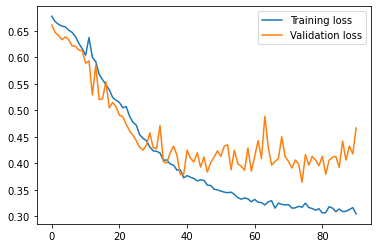

In [130]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label='Training loss')
plt.plot(val_loss_list, label='Validation loss')
plt.legend()
if not trial:
    plt.savefig(log_file_name[:-4] + ".png")
plt.show()

In [ ]:
def get_accuracy(yhat,y): #  FOR BCE ERROR
    
    if batched:
        batch_accuracy = []
        for batch in range(yhat.shape[0]):
            accuracy_list = []
            
            for i,entry in enumerate(yhat[batch]):
                softmax = torch.exp(entry.float())
                prob = list(softmax.cpu().detach().numpy())
                predictions = np.argmax(prob, axis=0)
                accuracy_list.append(np.argmax(y[batch][i].cpu().detach().numpy(), axis=0) == predictions != 0)
            batch_accuracy.append((np.sum(np.array(accuracy_list))*1.0)/len(accuracy_list))
            
        return np.sum(batch_accuracy)/len(batch_accuracy)
    
    else:
        
        accuracy_list = []
        #print (yhat.shape[0])
        for i,entry in enumerate(yhat):
            #if y[i].cpu().detach().numpy() != 0:
                #print (entry.shape)
            softmax = torch.exp(entry.float())
            prob = list(softmax.cpu().detach().numpy())
            predictions = np.argmax(prob, axis=0)
                #if random.random() > 0.99:
                #    print (predictions,y[i],y[i].cpu().detach().numpy())
            #print (yhat,predictions,y[i].cpu().detach().numpy())
            accuracy_list.append(y[i].cpu().detach().numpy() == predictions)
            
        return (np.sum(np.array(accuracy_list))*1.0)/len(yhat)

In [166]:
import sklearn.metrics as metrics

def get_predictions(yhat):
    predictions_list = []
    for i,entry in enumerate(yhat):
        softmax = torch.exp(entry.float())
        prob = list(softmax.cpu().detach().numpy())
        predictions = np.argmax(prob, axis=0)
        predictions_list.append(predictions)
    return predictions_list

def confusion_matrix(y,yhat):
    #print (y,yhat)
    fpr, tpr, threshold = metrics.roc_curve(y,yhat)
    #cm_val = sklearn.metrics.confusion_matrix(y,yhat)
    #tn, fp, fn, tp = cm_val.ravel()
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc, fpr, tpr

def test(val_dl,show_predictions=False):
    real_and_predictions = []
    model.eval()
    total_loss = []
    accuracy = []
    
    prediction_list = []
    y_ground_truth = []
    with torch.no_grad():
    
        val_dl.create_batches()
        loop = tqdm.tqdm(enumerate(val_dl.batches), total=len(val_dl),leave=False)
        for i,batch in loop:
            batch_text = [example["text"] for example in batch]
            batch_label = torch.tensor([example["label"] for example in batch])
            x_padded = pad_sequence(batch_text,batch_first=True, padding_value=0)
            #y_padded = pad_sequence(batch_label,batch_first=True, padding_value=0)
            xvalc = x_padded.to(device)
            yvalc = batch_label.to(device)
            y_ground_truth.extend(batch_label.cpu().detach().numpy())
            '''loop = tqdm.tqdm(enumerate(val_dl), total=len(val_dl),leave=False)
            for i, (xval,yval) in loop:
            xval = xval.view(1,-1)
            yval = yval.view(1,-1)
            xvalc = xval.to(device)
            yvalc = yval.to(device)'''

            # Forward prop
            output_val = model(xvalc.long(),yvalc)
            prediction_list.extend(get_predictions(output_val))
        
            accuracy.append(get_accuracy(output_val,yvalc))

            loss_val = criterion(output_val, yvalc)
            total_loss.append(loss_val.item())
            
            #print (one_hot_to_index(yvalc)[0],one_hot_to_index(output_val)[0])
            if show_predictions:
                if batched:
                    compound_list_original = index_to_word(yval_reshapedc.cpu().detach().numpy())
                    
                    compound_list_predicted = []
                    for i,entry in enumerate(output_val.view(len(yval_reshaped),-1,len(vocab))):
                        softmax = torch.exp(entry.float())
                        prob = list(softmax.cpu().detach().numpy())
                        predictions = np.argmax(prob, axis=1)
                        #print (predictions.shape,output_val.shape,len(compound_list_original[i]))
                        pred = ""
                        for i,entry in enumerate(predictions):
                            pred += index_word[entry]
                        compound_list_predicted.append(pred) 
                        
                    for i in range(len(compound_list_original)):
                        real_and_predictions.append((compound_list_original[i],compound_list_predicted[i]))
                else:
                    pred = ""
                    real = ""
                    softmax = torch.exp(output_val.float())
                    prob = list(softmax.cpu().detach().numpy())
                    predictions = np.argmax(prob, axis=1)
                    for i,entry in enumerate(predictions):
                        pred += en_index_word[entry]
                        #print (i)
                        real += en_index_word[yvalc.cpu().detach().numpy()[i]]
                    real_and_predictions.append((real,pred))
                    
    roc_auc, fpr, tpr = confusion_matrix(y_ground_truth,prediction_list)
    return (sum(total_loss)/(i+1),sum(accuracy)/(len(accuracy)),real_and_predictions,roc_auc, fpr, tpr)

In [167]:
loss,accuracy,prediction_list,roc_auc, fpr, tpr = test(test_iterator,False)

In [168]:
loss,accuracy

(0.5039357869275685, 0.817528735632184)

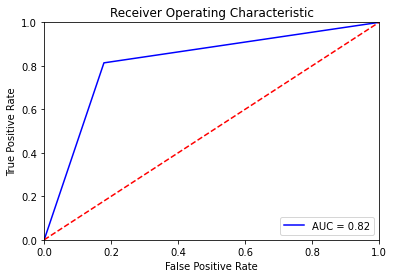

In [173]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
